<a href="https://colab.research.google.com/github/Abtin-Ghorbani/mastrs_project_XAI_pneumonia_detection/blob/main/masters_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dawnload dataset from Kaggle**

In [1]:
from google.colab import drive
import os
import shutil
import kagglehub
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q Kaggle
from google.colab import files
files.upload()
import os
# فقط در صورت نبود فایل zip، دانلود کن
if not os.path.exists("chest-xray-pneumonia.zip"):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
else:
    print(" Dataset ZIP already exists")
# فقط اگر فولدر chest_xray نیست، unzip کن
if not os.path.exists("dataset/chest_xray"):
    !unzip -q chest-xray-pneumonia.zip -d dataset
else:
    print(" Dataset already extracted")
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#  دانلود فقط اگر فایل ZIP هنوز وجود نداره
if not os.path.exists("chest-xray-pneumonia.zip"):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
else:
    print("Dataset ZIP already exists")

# ✅ استخراج فقط اگر فولدر اصلی chest_xray هنوز ساخته نشده
if not os.path.exists("dataset/chest_xray"):
    !unzip -n chest-xray-pneumonia.zip -d dataset
    !rm -rf dataset/__MACOSX  # حذف فایل‌های مزاحم مک
else:
    print("Dataset already extracted")


Saving kaggle.json to kaggle (6).json
 Dataset ZIP already exists
 Dataset already extracted
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset ZIP already exists
Dataset already extracted


In [3]:
import os

base_dir = '/content/dataset/chest_xray'
print(os.listdir(base_dir))#folder names

['chest_xray', 'train', 'test', '__MACOSX', 'val']


# **task 1 data preproccessing**

In [4]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [5]:
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'train'),
    validation_split=0.2,  # 20 of the data will be used for validation
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'train'),
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'test'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
for images, labels in train_ds.take(1):  # فقط یک batch می‌گیریم
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels.numpy())  # چاپ لیبل‌های واقعی

Images shape: (32, 224, 224, 3)
Labels shape: (32, 1)
Labels: [[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


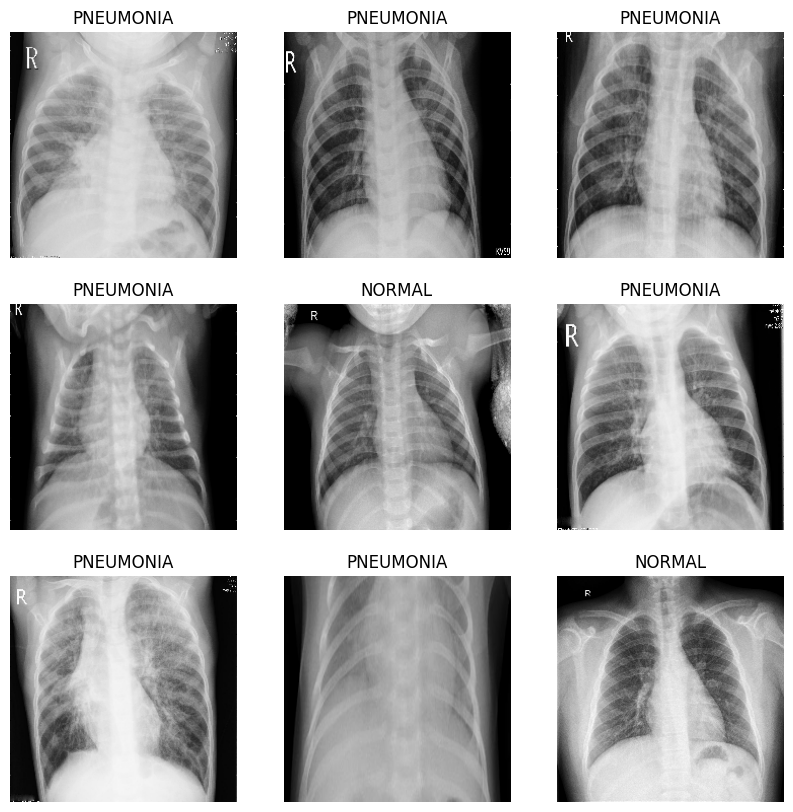

In [8]:
import matplotlib.pyplot as plt

class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

# **Normalization**

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [10]:
def preprocess(image, label):
    image = preprocess_input(image)  # between mobile net [-1, 1]
    return image, label
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# **buld and Train CNN model for pneumonia classification**

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

In [12]:
# Load the base MobileNetV2 model without the top classification layers
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False# Freeze the base model so its weights do not change during training

# **buil model **

In [13]:
# Build the full model on top of MobileNetV2
model_mobilenet = models.Sequential([
    base_model,   # Pretrained convolutional base
    layers.GlobalAveragePooling2D(),  # Reduce feature map to vector (1280)
    layers.Dropout(0.2),   #to prevent overfitting
    layers.Dense(1, activation='sigmoid') #  Pneumonia or normal
])

# **compile the model **

In [14]:
# Compile the model with optimizer, loss, and metric
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',                                # For binary classification
    metrics=['accuracy']
)

# **train model with images**

In [15]:
# Train the model using early stopping
history = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 161ms/step - accuracy: 0.5077 - loss: 0.7955 - val_accuracy: 0.7881 - val_loss: 0.4315
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7742 - loss: 0.4602 - val_accuracy: 0.8485 - val_loss: 0.3407
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8360 - loss: 0.3795 - val_accuracy: 0.9108 - val_loss: 0.2801
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8806 - loss: 0.3226 - val_accuracy: 0.9425 - val_loss: 0.2392
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9014 - loss: 0.2758 - val_accuracy: 0.9511 - val_loss: 0.2092
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9169 - loss: 0.2532 - val_accuracy: 0.9549 - val_loss: 0.1866
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9259 - loss: 0.2284 - val_accuracy: 0.9655 - val_loss: 0.1710
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9313 - loss: 0.2061 - val_

**save model tranfer learning**

In [16]:
model_mobilenet.save("mobilenetv2_transfer_only_final.keras")

# **evaluate model**

In [17]:
# Evaluate the model on test data
test_loss, test_acc = model_mobilenet.evaluate(test_ds)
print(f"Test Accuracy for mobile net: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.8115 - loss: 0.3592
Test Accuracy for mobile net: 0.8093


# **fine tune model**

In [18]:
from tensorflow.keras.models import clone_model

model_finetuned = clone_model(model_mobilenet)#copy the previos model
model_finetuned.set_weights(model_mobilenet.get_weights())


In [19]:
base_model = model_finetuned.layers[0]
base_model.trainable = True

#unfreeze the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [20]:
model_finetuned.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint(
    "mobilenetv2_best_val_loss.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    mode="min",
    verbose=1
)

In [22]:
history_fine = model_finetuned.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/15
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9146 - loss: 0.2116
Epoch 1: val_loss improved from inf to 0.07541, saving model to mobilenetv2_best_val_loss.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.9149 - loss: 0.2110 - val_accuracy: 0.9779 - val_loss: 0.0754
Epoch 2/15
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9676 - loss: 0.0977
Epoch 2: val_loss improved from 0.07541 to 0.06588, saving model to mobilenetv2_best_val_loss.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.9676 - loss: 0.0978 - val_accuracy: 0.9837 - val_loss: 0.0659
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9759 - loss: 0.0742
Epoch 3: val_loss improved from 0.06588 to 0.06030, saving model to mobilenetv2_best_val_loss.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9759 - loss: 0.0742 - val_accuracy: 0.9827 - val_loss: 0.0603
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9855 - loss: 0.055

**save finetuned model**

In [23]:
model_finetuned.save("mobilenetv2_finetuned_final.keras")

In [25]:
# Evaluate the model on test data
test_loss, test_acc = model_finetuned.evaluate(test_ds)
print(f"Test Accuracy after fine tuning: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.8818 - loss: 0.3669
Test Accuracy after fine tuning: 0.8574


**evaluate transfer learnin method**

In [34]:
from tensorflow.keras.models import load_model

model_mobilenet = load_model("mobilenetv2_transfer_only_final.keras")

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: predicts and labels
y_true_befor = []
y_pred_befor = []
for images, labels in test_ds:
    preds_befor = model_mobilenet.predict(images)
    preds_befor = (preds_befor > 0.6).astype("int32")  # آستانه‌ی sigmoid
    y_true_befor.extend(labels.numpy())
    y_pred_befor.extend(preds_befor)

# Step 2 evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_true_befor, y_pred_befor))

print("\nClassification Report:")
print(classification_report(y_true_befor, y_pred_befor, target_names=['NORMAL', 'PNEUMONIA']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix:
[[133 101]
 [  4 386]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.57      0.72       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy   

In [36]:
finetuned_model = load_model("mobilenetv2_finetuned_final.keras")

**fine tune evaluate**

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: predicts and labels
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = finetuned_model.predict(images)
    preds = (preds > 0.6).astype("int32")  # آستانه‌ی sigmoid
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Step 2 evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix:
[[155  79]
 [  3 387]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.66      0.79       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy   